<a href="https://colab.research.google.com/github/rezzycavalheiro/PSR_PT-BR/blob/master/AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Sample code from https://www.redblobgames.com/pathfinding/a-star/
# Copyright 2014 Red Blob Games <redblobgames@gmail.com>
#
# Feel free to use this code in your own projects, including commercial projects
# License: Apache v2.0 <http://www.apache.org/licenses/LICENSE-2.0.html>

# https://www.redblobgames.com/pathfinding/a-star/implementation.html#python-breadth-first

class SimpleGraph:
    def __init__(self):
        self.edges = {}
    #self inicia o objeto dentro da classe, nesse caso um array chamado edges.
    
    def neighbors(self, id):
        return self.edges[id]
    #id Ã© o nome dado ao nÃ³

example_graph = SimpleGraph()
example_graph.edges = {
    'A': ['B'],
    'B': ['A', 'C', 'D'],
    'C': ['A'],
    'D': ['E', 'A'],
    'E': ['B']
}

import collections

class Queue:
    def __init__(self):
        self.elements = collections.deque()
    #classe para fazer a fila para guardar os elementos
    
    def empty(self):
        return len(self.elements) == 0
    #retorna o tamanho da fila
    
    def put(self, x):
        self.elements.append(x)
    
    def get(self):
        return self.elements.popleft()

# utility functions for dealing with square grids
def from_id_width(id, width):
    return (id % width, id // width)

def draw_tile(graph, id, style, width):
    r = "."
    if 'number' in style and id in style['number']: r = "%d" % style['number'][id]
    if 'point_to' in style and style['point_to'].get(id, None) is not None:
        (x1, y1) = id
        (x2, y2) = style['point_to'][id]
        if x2 == x1 + 1: r = ">"
        if x2 == x1 - 1: r = "<"
        if y2 == y1 + 1: r = "v"
        if y2 == y1 - 1: r = "^"
    if 'start' in style and id == style['start']: r = "A"
    if 'goal' in style and id == style['goal']: r = "Z"
    if 'path' in style and id in style['path']: r = "@"
    if id in graph.walls: r = "#" * width
    return r

def draw_grid(graph, width=2, **style):
    for y in range(graph.height):
        for x in range(graph.width):
            print("%%-%ds" % width % draw_tile(graph, (x, y), style, width), end='')
        print()

# data from main article
DIAGRAM1_WALLS = [from_id_width(id, width=30) for id in [21,22,51,52,81,82,93,94,111,112,123,124,133,134,141,142,153,154,163,164,171,172,173,174,175,183,184,193,194,201,202,203,204,205,213,214,223,224,243,244,253,254,273,274,283,284,303,304,313,314,333,334,343,344,373,374,403,404,433,434]]

class SquareGrid:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.walls = []
    
    def in_bounds(self, id):
        (x, y) = id
        return 0 <= x < self.width and 0 <= y < self.height
    
    def passable(self, id):
        return id not in self.walls
    
    def neighbors(self, id):
        (x, y) = id
        results = [(x+1, y), (x, y-1), (x-1, y), (x, y+1)]
        if (x + y) % 2 == 0: results.reverse() # aesthetics
        results = filter(self.in_bounds, results)
        results = filter(self.passable, results)
        return results

class GridWithWeights(SquareGrid):
    def __init__(self, width, height):
        super().__init__(width, height)
        self.weights = {}
    
    def cost(self, from_node, to_node):
        return self.weights.get(to_node, 1)

diagram4 = GridWithWeights(10, 10)
diagram4.walls = [(1, 7), (1, 8), (2, 7), (2, 8), (3, 7), (3, 8)]
diagram4.weights = {loc: 5 for loc in [(3, 4), (3, 5), (4, 1), (4, 2),
                                       (4, 3), (4, 4), (4, 5), (4, 6), 
                                       (4, 7), (4, 8), (5, 1), (5, 2),
                                       (5, 3), (5, 4), (5, 5), (5, 6), 
                                       (5, 7), (5, 8), (6, 2), (6, 3), 
                                       (6, 4), (6, 5), (6, 6), (6, 7), 
                                       (7, 3), (7, 4), (7, 5)]}

import heapq

class PriorityQueue:
    def __init__(self):
        self.elements = []
    
    def empty(self):
        return len(self.elements) == 0
    
    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))
    
    def get(self):
        return heapq.heappop(self.elements)[1]

def dijkstra_search(graph, start, goal):
    frontier = PriorityQueue()
    frontier.put(start, 0)
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():
        current = frontier.get()
        
        if current == goal:
            break
        
        for next in graph.neighbors(current):
            new_cost = cost_so_far[current] + graph.cost(current, next)
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost
                frontier.put(next, priority)
                came_from[next] = current
    
    return came_from, cost_so_far

# thanks to @m1sp <Jaiden Mispy> for this simpler version of
# reconstruct_path that doesn't have duplicate entries

def reconstruct_path(came_from, start, goal):
    current = goal
    path = []
    while current != start:
        path.append(current)
        current = came_from[current]
    path.append(start) # optional
    path.reverse() # optional
    return path

def heuristic(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)

def a_star_search(graph, start, goal):
    frontier = PriorityQueue()
    frontier.put(start, 0)
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():
        current = frontier.get()
        
        if current == goal:
            break
        
        for next in graph.neighbors(current):
            new_cost = cost_so_far[current] + graph.cost(current, next)
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + heuristic(goal, next)
                frontier.put(next, priority)
                came_from[next] = current
    
    return came_from, cost_so_far
  

def breadth_first_search_2(graph, start):
    # return "came_from"
    frontier = Queue()
    frontier.put(start)
    came_from = {}
    came_from[start] = None
    
    while not frontier.empty():
        current = frontier.get()
        for next in graph.neighbors(current):
            if next not in came_from:
                frontier.put(next)
                came_from[next] = current
    
    return came_from

g = SquareGrid(30, 15)
g.walls = DIAGRAM1_WALLS

parents = breadth_first_search_2(g, (8, 7))
draw_grid(g, width=2, point_to=parents, start=(8, 7))

g = SquareGrid(30,15)
g.walls = DIAGRAM1_WALLS # long list, [(21, 0), (21, 2), ...]
draw_grid(g)

def breadth_first_search_1(graph, start):
    # print out what we find
    frontier = Queue()
    frontier.put(start)
    visited = {}
    visited[start] = True
    
    while not frontier.empty():
        current = frontier.get()
        print("Visitando %r" % current)
        for next in graph.neighbors(current):
            if next not in visited:
                frontier.put(next)
                visited[next] = True

#breadth_first_search1(grafo,ponto inicial do grafo - tipo A, B, C, etc.)
breadth_first_search_1(example_graph, 'A')





> > > > v v v v v v v v v v v v < < < < < ####v v v v v v v 
> > > > > v v v v v v v v v v < < < < < < ####v v v v v v v 
> > > > > v v v v v v v v v < < < < < < < ####> v v v v v v 
> > ^ ####v v v v v v v v < < < < < < < < ####> > v v v v v 
> ^ ^ ####> v v v v v v < ####^ < < < < < ####> > > v v v v 
^ ^ ^ ####> > v v v v < < ####^ ^ < < < < ##########v v v < 
^ ^ ^ ####> > > v v < < < ####^ ^ ^ < < < ##########v v < < 
^ ^ ^ ####> > > A < < < < ####^ ^ ^ ^ < < < < < < < < < < < 
v v v ####> > ^ ^ ^ < < < ####^ ^ ^ ^ ^ < < < < < < < < < < 
v v v ####> ^ ^ ^ ^ ^ < < ####^ ^ ^ ^ ^ ^ < < < < < < < < < 
v v v ####^ ^ ^ ^ ^ ^ ^ < ####^ ^ ^ ^ ^ ^ ^ < < < < < < < < 
> v v ####^ ^ ^ ^ ^ ^ ^ ^ ####^ ^ ^ ^ ^ ^ ^ ^ < < < < < < < 
> > > > > ^ ^ ^ ^ ^ ^ ^ ^ ####^ ^ ^ ^ ^ ^ ^ ^ ^ < < < < < < 
> > > > ^ ^ ^ ^ ^ ^ ^ ^ ^ ####^ ^ ^ ^ ^ ^ ^ ^ ^ ^ < < < < < 
> > > ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ####^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ < < < < 
. . . . . . . . . . . . . . . . . . . . . ####. . . . . . . 
. . . . . . . . . . . . 

Cities:
[(117,186), (32,27), (19,77), (137,96), (136,83), (18,23), (88,191), (156,62), (110,103), (4,83), (199,47), (95,143), (175,157), (102,101), (129,150), (76,111), (25,96), (179,104), (125,132), (18,179), (35,11), (189,11), (143,184), (63,155), (162,148)]


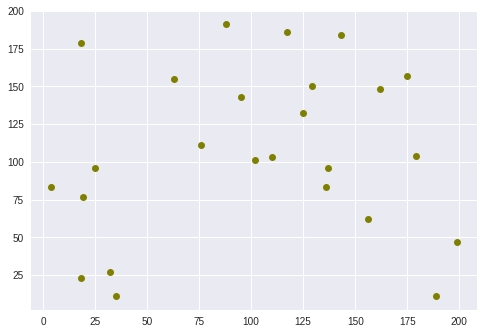

Initial distance: 2175.6925253577297
Final distance: 943.3684400705694
BestRoute:
[(117,186), (143,184), (175,157), (162,148), (129,150), (125,132), (95,143), (76,111), (102,101), (110,103), (137,96), (136,83), (156,62), (179,104), (199,47), (189,11), (35,11), (32,27), (18,23), (19,77), (4,83), (25,96), (18,179), (63,155), (88,191)]


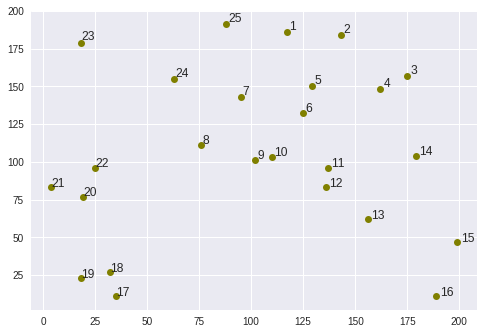

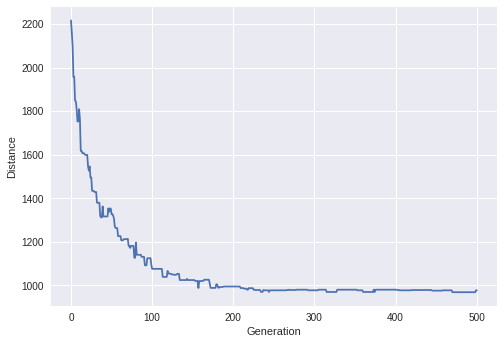

In [1]:
# Adaptado do blog
# https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35

import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"
      
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness
      
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route
  
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population
  
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults
  
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool
  
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child
  
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children
  
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual
  
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop
  
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration
  
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute
  
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))  

print("Cities:")
print(cityList)
for pt in cityList:
   plt.plot(pt.x, pt.y, '-ok', linestyle='solid', linewidth=4, color='olive')
plt.show()
    
best=geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

print(("BestRoute:"))
print(best)

i=0
for pt in best:
   i=i+1
   plt.plot(pt.x, pt.y, '-ok', linestyle='solid', linewidth=4, color='olive')
   plt.text(pt.x * (1 + 0.01), pt.y * (1 + 0.01) , i, fontsize=12)
plt.show()


geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)